<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/Lecture_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning Notebook
From https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html

Modified by J.R. Green, 11Nov2019 (fixed typos, added comments)

In [0]:
%matplotlib inline


# Label Propagation digits active learning


Demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 40 labeled points,
then we select the top five most uncertain points to label. Next, we train
with 45 labeled points (original 40 + 5 new ones). We repeat this process
four times to have a model trained with 60 labeled examples. Note you can
increase this to label more than 60 by changing `max_iterations`. Labeling
more than 60 can be useful to get a sense for the speed of convergence of
this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.



Automatically created module for IPython interactive environment
Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Confusion matrix
[[22  0  0  0 

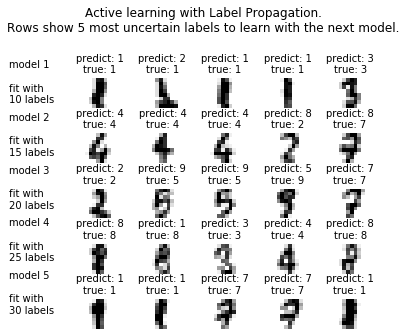

In [1]:
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset and shuffle the order of data
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

# Grab a subset of the data (330 random labelled samples)
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40     # Start with 40 labelled points
max_iterations = 5        # Will have 5 iterations. Add 5 newly labelled points at each iteration.

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:] # Create nparray of indices between 40..329
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1   # Use -1 label to indicate to label propagation algorithm that these samples are unlabelled

    # Train a label propagation model. This is based on "transductive learning"
    # K-NN is an example of transductive learning. Label unlabelled samples,
    # given labels of few known training samples...
    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    # Use trained model to predict labels for unlabelled samples
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    # Compute the confusion matrix and print performance at each iteration
    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    # Here, entropy is used a measure of uncertainty
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remove from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()